In [257]:
# import stuff
import os, sys, time
import tifffile as tif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [641]:
# load label csvs 
lab_fischer = pd.read_csv('/Users/emilydennis/Desktop/sagittal_fischer_labels_withPRA.csv')
lab_sigma = pd.read_csv('/Users/emilydennis/Desktop/SIGMA_labels_withPRA.csv')
lab_schwarz = pd.read_csv('/Users/emilydennis/Desktop/sagittal_schwarz_labels_withPRA.csv')

In [747]:
# load labeled volumes
fischer = tif.imread('/Users/emilydennis/Desktop/sagittal_fischer_in_mPRA.tif')
sigma = tif.imread('/Users/emilydennis/Desktop/mPRA_SIGMA_annotation-volume.tif')
schwarz = tif.imread('/Users/emilydennis/Desktop/sagittal_schwarz_in_mPRA.tif')

In [391]:
# add a mask of the atlas
mpramask = tif.imread('/Users/emilydennis/Desktop/new/today/mPRA-mask.tif')

In [597]:
# get all dissimilarity values for each overlapping set in two labeled volumes
def get_dissimilarity(Alab,Aval,Blab,Bval):
    nameA = get_name(Alab,Aval)
    print(nameA)
    familytreeA = get_hierarchy(Alab,nameA)
    nameB = get_name(Blab,Bval)
    print(nameB)
    familytreeB = get_hierarchy(Blab,nameB)
    if len(familytreeA) > len(familytreeB):
        # if family tree A longer than B
        diss = get_diss_value(familytreeA,familytreeB)
    elif len(familytreeB) > len(familytreeA):
        diss = get_diss_value(familytreeB,familytreeA)
    else:
        da = get_diss_value(familytreeA,familytreeB)
        db = get_diss_value(familytreeB,familytreeA)
        diss = min(da,db)
    return diss


In [598]:
# calculate a dissimilarity value for two lists
def get_diss_value(longerfamilytree,shorterfamilytree):
    diss=0
    while longerfamilytree.count(shorterfamilytree[diss]) == 0:
        diss+=1
    return diss

In [599]:
# relate two labeled volumes
def get_a_b(A,Alab,B,Blab,mask):
    [xmax,ymax,zmax] = np.shape(mask)
    badlist=[]
    distlist = []
    for x in np.arange(0,xmax):
        print(x)
        for y in np.arange(0,ymax):
            for z in np.arange(0,zmax):
                if mask[x,y,z] > 0:
                    #for each non zero voxel, get values
                    [Aname,Aparent] = get_parent(A,Alab,x,y,z)
                    [Bname,Bparent] = get_parent(B,Blab,x,y,z)
                    if np.all([Aname!=Bname,Aname!=Bparent,Aparent!=Bparent,Aname!=0,Bname!=0]):
                        badlist.append([x,y,z,Aname,Bname])
    return badlist

In [628]:
# get a name for a value from a labeled volume
def get_name_from_val(labeledvolume, val):
    valname = labeledvolume.loc[labeledvolume.ID==val,'name'].values[0]
    return valname

In [601]:
# get the name and parent from a position in a given volume
# note that numpy arrays are z y x when viewing the tiff
def get_parent_from_pos(volume,labeledvolume,x,y,z):
    # assumes you have a column called 'parent'
    val = volume[x,y,z]
    if val > 0:
        valname = get_name(labeledvolume, val)
        parentname = get_parent_from_name(labeledvolume,valname)
    else:
        valname=0
        parentname=0
    return valname, parentname

In [602]:
# get the parent name of a given name/volume
def get_parent_from_name(labeledvolume,name):
    parentname=labeledvolume.loc[labeledvolume.name == name,'parent'].values[0]
    return parentname

In [603]:
# get the hierarchy/family tree of a given name in a given volume
def get_hierarchy(labeledvolume,name):
    familytree = [name]
    parentname = get_parent_from_name(labeledvolume,name)
    familytree.append(parentname)

    while parentname != 'root':
        print(parentname)
        parentname = get_parent_from_name(labeledvolume,parentname)
        familytree.append(parentname)
    return familytree

In [604]:
# make a list of all values that overlap in the two atlases where mask == 1
def get_overlapping_values(A,Alab,B,mask):
    overlapping_list=[]
    for idno in Alab.ID:
        if np.isnan(idno) == 0:
            print(idno)
            m = A==idno
            overlapping_list.append([idno,np.unique(m*[mask>0]*B)])
    return overlapping_list

In [605]:
#for a column in a df, replace spaces with _ and make all lowercase
def make_column_safe(df,num):
    for idx in df.index:
        strfx = df[num][idx]
        strfx = strfx.replace(' ','_').lower()
        df[num][idx] = strfx
    return df

# example of how to use:

In [ ]:
overlapping_list = get_overlapping_values(fischer, lab_fischer, sigma, lab_sigma)

In [608]:
np.save('/Users/emilydennis/Desktop/sigma_fischer_overlapping_list.npy',overlapping_list)

In [495]:
dissimilarities = []
for i in np.arange(0,len(overlapping_list)):
    val_fischer = overlapping_list[i][0]

    for j in np.arange(0,len(overlapping_list[i][1])):
        print(i,j)
        val_sigma = overlapping_list[i][1][j]
        if val_sigma > 0:
            dissimilarities.append([i,j,get_dissimilarity(lab_fischer,val_fischer,lab_sigma,val_sigma)])

0 0
0 1
anterior_part_of_anterior_commissure
fiber_tract
basal_forebrain
forebrain
cerebrum
0 2
anterior_part_of_anterior_commissure
fiber_tract
basal_forebrain
forebrain
cerebrum
0 3
anterior_part_of_anterior_commissure
fiber_tract
bed_nucleus_of_the_stria_terminalis
forebrain
cerebrum
0 4
anterior_part_of_anterior_commissure
fiber_tract
olfactory_bulb
0 5
anterior_part_of_anterior_commissure
fiber_tract
prelimbic_system
perirhinal
hippocampal_formation
cortex
cerebrum
0 6
anterior_part_of_anterior_commissure
fiber_tract
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
0 7
anterior_part_of_anterior_commissure
fiber_tract
anterior_commissure_intraolfactory_bulbar_part
cranial_nerves
0 8
anterior_part_of_anterior_commissure
fiber_tract
anterior_part_of_anterior_commissure
cranial_nerves
0 9
anterior_part_of_anterior_commissure
fiber_tract
anterior_part_of_anterior_commissure
cranial_nerves
0 10
anterior_part_of_anterior_commissure
fiber_tract
anterior_commissure_posterior_part


cerebellar_lobule_1/2
cerebellum
periaqueductal_gray
midbrain_motor
midbrain
cerebrum
5 7
cerebellar_lobule_1/2
cerebellum
brainstem
5 8
cerebellar_lobule_1/2
cerebellum
brainstem
5 9
cerebellar_lobule_1/2
cerebellum
external_cortex_of_the_inferior_colliculus_
inferior_colliculus
midbrain
cerebrum
5 10
cerebellar_lobule_1/2
cerebellum
external_cortex_of_the_inferior_colliculus_
inferior_colliculus
midbrain
cerebrum
5 11
cerebellar_lobule_1/2
cerebellum
middle_cerebellum_peduncle_
cerebellum
5 12
cerebellar_lobule_1/2
cerebellum
periventricular_grey
thalamus
cerebrum
5 13
cerebellar_lobule_1/2
cerebellum
periventricular_grey
thalamus
cerebrum
6 0
6 1
cerebellar_lobule_10
cerebellum
granule_cell_level_of_the_cerebellum
cerebellum
6 2
cerebellar_lobule_10
cerebellum
granule_cell_level_of_the_cerebellum
cerebellum
6 3
cerebellar_lobule_10
cerebellum
molecular_layer_of_the_cerebellum
cerebellum
6 4
cerebellar_lobule_10
cerebellum
molecular_layer_of_the_cerebellum
cerebellum
6 5
cerebellar_l

pretectal_region
midbrain_motor
midbrain
cerebrum
18 4
commissure_of_the_superior_collicuus
fiber_tract
commissure_of_the_superior_colliculus
fiber_tract
18 5
commissure_of_the_superior_collicuus
fiber_tract
commissure_of_the_superior_colliculus
fiber_tract
18 6
commissure_of_the_superior_collicuus
fiber_tract
deeper_layers_of_the_superior_colliculus
superior_colliculus
midbrain
cerebrum
18 7
commissure_of_the_superior_collicuus
fiber_tract
deeper_layers_of_the_superior_colliculus
superior_colliculus
midbrain
cerebrum
18 8
commissure_of_the_superior_collicuus
fiber_tract
posterior_commissure
fiber_tract
18 9
commissure_of_the_superior_collicuus
fiber_tract
posterior_commissure
fiber_tract
19 0
19 1
copula
cerebellum
granule_cell_level_of_the_cerebellum
cerebellum
19 2
copula
cerebellum
molecular_layer_of_the_cerebellum
cerebellum
20 0
20 1
corpus_callosum/external_capsule
fiber_tract
agranular_dysgranular_insular_cortex
insula
cortex
cerebrum
20 2
corpus_callosum/external_capsule
fiber

primary_somatosensory_cortex_jaw
somatosensory
cortex
cerebrum
20 87
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex
somatosensory
cortex
cerebrum
20 88
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex
somatosensory
cortex
cerebrum
20 89
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex_shoulder
somatosensory
cortex
cerebrum
20 90
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex_shoulder
somatosensory
cortex
cerebrum
20 91
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex_trunk
somatosensory
cortex
cerebrum
20 92
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex_trunk
somatosensory
cortex
cerebrum
20 93
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex_upperlips
somatosensory
cortex
cerebrum
20 94
corpus_callosum/external_capsule
fiber_tract
primary_somatosensory_cortex_upperlips
somatosensory
cortex
cerebrum
20 95
c

cerebrum
21 50
cortex
cerebrum
primary_somatosensory_cortex_hindlimb
somatosensory
cortex
cerebrum
21 51
cortex
cerebrum
primary_somatosensory_cortex_jaw
somatosensory
cortex
cerebrum
21 52
cortex
cerebrum
primary_somatosensory_cortex
somatosensory
cortex
cerebrum
21 53
cortex
cerebrum
primary_somatosensory_cortex_shoulder
somatosensory
cortex
cerebrum
21 54
cortex
cerebrum
primary_somatosensory_cortex_trunk
somatosensory
cortex
cerebrum
21 55
cortex
cerebrum
primary_somatosensory_cortex_upperlips
somatosensory
cortex
cerebrum
21 56
cortex
cerebrum
primary_visual_cortex_binocular_area
visual
cortex
cerebrum
21 57
cortex
cerebrum
primary_visual_cortex
visual
cortex
cerebrum
21 58
cortex
cerebrum
primary_visual_cortex_monocular_area
visual
cortex
cerebrum
21 59
cortex
cerebrum
retosplenial_dysgranular_cortex
cingulate
cortex
cerebrum
21 60
cortex
cerebrum
retosplenial_dysgranular_cortex
cingulate
cortex
cerebrum
21 61
cortex
cerebrum
retrosplenial_granular_cortex_part_a
cingulate
cortex


globus_pallidus
pallidum
basal_ganglia
basal_forebrain
cerebrum
basal_forebrain
forebrain
cerebrum
34 2
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
cerebrum
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
forebrain
cerebrum
34 3
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
cerebrum
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
34 4
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
cerebrum
corpus_callosum_and_associated_subcortical_white_matter
fiber_tract
34 5
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
cerebrum
descending_corticofugal_pathways_and_globus_pallidum
pallidum
basal_ganglia
basal_forebrain
forebrain
cerebrum
34 6
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
cerebrum
fimbria_of_the_hippocampal_formation
medial_forebrain_bundle
forebrain
cerebrum
35 0
35 1
hindbrain
brainstem
granule_cell_level_of_the_cerebellum
cerebellum
35 2
hindbrain
brainstem
granule_cell_level_of_the_cerebellum
cerebellum
35 3
hindbrain

cerebrum
anterior_commissure_intraolfactory_bulbar_part
cranial_nerves
42 0
42 1
lateral_olfactory_tract
olfactory_areas
cerebrum
basal_forebrain
forebrain
cerebrum
42 2
lateral_olfactory_tract
olfactory_areas
cerebrum
olfactory_bulb
43 0
43 1
lateral_septum
pallidum
basal_ganglia
basal_forebrain
cerebrum
basal_forebrain
forebrain
cerebrum
43 2
lateral_septum
pallidum
basal_ganglia
basal_forebrain
cerebrum
basal_forebrain
forebrain
cerebrum
43 3
lateral_septum
pallidum
basal_ganglia
basal_forebrain
cerebrum
bed_nucleus_of_the_stria_terminalis
forebrain
cerebrum
43 4
lateral_septum
pallidum
basal_ganglia
basal_forebrain
cerebrum
prelimbic_system
perirhinal
hippocampal_formation
cortex
cerebrum
43 5
lateral_septum
pallidum
basal_ganglia
basal_forebrain
cerebrum
prelimbic_system
perirhinal
hippocampal_formation
cortex
cerebrum
43 6
lateral_septum
pallidum
basal_ganglia
basal_forebrain
cerebrum
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
43 7
lateral_septum
pallidum
basal_gan

basal_ganglia
basal_forebrain
forebrain
cerebrum
47 15
medial_septum
pallidum
basal_ganglia
basal_forebrain
cerebrum
septal_region
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
48 0
48 1
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
basal_forebrain
forebrain
cerebrum
48 2
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
basal_forebrain
forebrain
cerebrum
48 3
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
anterior_part_of_anterior_commissure
cranial_nerves
48 4
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
anterior_part_of_anterior_commissure
cranial_nerves
48 5
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
anterior_commissure_posterior_part
cranial_nerves
48 6
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
anterior_commissure_posterior_part
cranial_nerves
48 7
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
fornix
medial_forebrain_bundle
forebrain
cerebrum
48 8
median_preoptic_nucleus
hypothalamus
midbrain
cerebrum
fo

56 15
periaqueductal_grey
midbrain
cerebrum
fasciculus_retroflexus
medial_forebrain_bundle
forebrain
cerebrum
56 16
periaqueductal_grey
midbrain
cerebrum
external_cortex_of_the_inferior_colliculus_
inferior_colliculus
midbrain
cerebrum
56 17
periaqueductal_grey
midbrain
cerebrum
external_cortex_of_the_inferior_colliculus_
inferior_colliculus
midbrain
cerebrum
56 18
periaqueductal_grey
midbrain
cerebrum
posterior_commissure
fiber_tract
56 19
periaqueductal_grey
midbrain
cerebrum
posterior_commissure
fiber_tract
56 20
periaqueductal_grey
midbrain
cerebrum
thalamus
cerebrum
56 21
periaqueductal_grey
midbrain
cerebrum
thalamus
cerebrum
56 22
periaqueductal_grey
midbrain
cerebrum
periventricular_grey
thalamus
cerebrum
56 23
periaqueductal_grey
midbrain
cerebrum
periventricular_grey
thalamus
cerebrum
57 0
57 1
pons
hindbrain
brainstem
interpeduncular_nucleus
cerebellum
57 2
pons
hindbrain
brainstem
interpeduncular_nucleus
cerebellum
57 3
pons
hindbrain
brainstem
molecular_layer_of_the_cerebe

hippocampal_formation
cortex
cerebrum
65 3
superior_colliculus
midbrain
cerebrum
periaqueductal_gray
midbrain_motor
midbrain
cerebrum
65 4
superior_colliculus
midbrain
cerebrum
periaqueductal_gray
midbrain_motor
midbrain
cerebrum
65 5
superior_colliculus
midbrain
cerebrum
pretectal_region
midbrain_motor
midbrain
cerebrum
65 6
superior_colliculus
midbrain
cerebrum
retosplenial_dysgranular_cortex
cingulate
cortex
cerebrum
65 7
superior_colliculus
midbrain
cerebrum
retrosplenial_granular_cortex_part_a
cingulate
cortex
cerebrum
65 8
superior_colliculus
midbrain
cerebrum
subiculum
retrohippocampal
hippocampal_formation
cortex
cerebrum
65 9
superior_colliculus
midbrain
cerebrum
superficial_gray_layer_of_the_superior_colliculus
superior_colliculus
midbrain
cerebrum
65 10
superior_colliculus
midbrain
cerebrum
superficial_gray_layer_of_the_superior_colliculus
superior_colliculus
midbrain
cerebrum
65 11
superior_colliculus
midbrain
cerebrum
brainstem
65 12
superior_colliculus
midbrain
cerebrum
c

external_cortex_of_the_inferior_colliculus_
inferior_colliculus
midbrain
cerebrum
72 6
aqueduct
ventricle
external_cortex_of_the_inferior_colliculus_
inferior_colliculus
midbrain
cerebrum
72 7
aqueduct
ventricle
periventricular_grey
thalamus
cerebrum
72 8
aqueduct
ventricle
periventricular_grey
thalamus
cerebrum
73 0
73 1
basal_forebrain
cerebrum
basal_forebrain
forebrain
cerebrum
73 2
basal_forebrain
cerebrum
basal_forebrain
forebrain
cerebrum
73 3
basal_forebrain
cerebrum
bed_nucleus_of_the_stria_terminalis
forebrain
cerebrum
73 4
basal_forebrain
cerebrum
bed_nucleus_of_the_stria_terminalis
forebrain
cerebrum
73 5
basal_forebrain
cerebrum
entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
73 6
basal_forebrain
cerebrum
entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
73 7
basal_forebrain
cerebrum
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
forebrain
cerebrum
73 8
basal_forebrain
cerebrum
globus_pallidus
pallidum
basal_ganglia
ba

83 4
cerebellar_lobule_9
cerebellum
molecular_layer_of_the_cerebellum
cerebellum
84 0
84 1
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum
ectorhinal_cortex
perirhinal
hippocampal_formation
cortex
cerebrum
84 2
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum
granule_cell_level_of_the_cerebellum
cerebellum
84 3
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum
granule_cell_level_of_the_cerebellum
cerebellum
84 4
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum
molecular_layer_of_the_cerebellum
cerebellum
84 5
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum
molecular_layer_of_the_cerebellum
cerebellum
84 6
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum
perirhinal_cortex
perirhinal
hippocampal_formation
cortex
cerebrum
84 7
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum
retosplenial_dysgranular_cortex
cingulate
cortex
cerebrum
84 8
cerebellar_white_matter/arbor_vitae_of_cerebellum_
cerebellum


cortex
cerebrum
91 48
corpus_callosum/external_capsule
fiber_tract
orbitofrontal_region
orbital
cortex
cerebrum
91 49
corpus_callosum/external_capsule
fiber_tract
parasubiculum
retrohippocampal
hippocampal_formation
cortex
cerebrum
91 50
corpus_callosum/external_capsule
fiber_tract
parasubiculum
retrohippocampal
hippocampal_formation
cortex
cerebrum
91 51
corpus_callosum/external_capsule
fiber_tract
parietal_cortex_postero_caudal_part
parietal
cortex
cerebrum
91 52
corpus_callosum/external_capsule
fiber_tract
parietal_cortex_postero_caudal_part
parietal
cortex
cerebrum
91 53
corpus_callosum/external_capsule
fiber_tract
parietal_cortex_postero_dorsal_part
parietal
cortex
cerebrum
91 54
corpus_callosum/external_capsule
fiber_tract
parietal_cortex_postero_dorsal_part
parietal
cortex
cerebrum
91 55
corpus_callosum/external_capsule
fiber_tract
parietal_cortex_postero_rostral
parietal
cortex
cerebrum
91 56
corpus_callosum/external_capsule
fiber_tract
parietal_cortex_postero_rostral
parietal


cerebrum
dysgranular_insular_cortex
insula
cortex
cerebrum
92 12
cortex
cerebrum
ectorhinal_cortex
perirhinal
hippocampal_formation
cortex
cerebrum
92 13
cortex
cerebrum
entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
92 14
cortex
cerebrum
frontal_association_cortex
frontal_pole
cortex
cerebrum
92 15
cortex
cerebrum
globus_pallidus
pallidum
basal_ganglia
basal_forebrain
forebrain
cerebrum
92 16
cortex
cerebrum
glomerular_layer_of_the_accessory_olfactory_bulb
olfactory_bulb
92 17
cortex
cerebrum
lateral_temporal_associative_cortex
auditory
cortex
cerebrum
92 18
cortex
cerebrum
lateral_primary_auditory_cortex
auditory
cortex
cerebrum
92 19
cortex
cerebrum
lateral_entorhinal_cortex_internal_part
retrohippocampal
hippocampal_formation
cortex
cerebrum
92 20
cortex
cerebrum
lateral_entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
92 21
cortex
cerebrum
lateral_entorhinal_cortex_external_part
retrohippocampal
hippocampal_formation
cortex
cerebru

hippocampal_formation
cerebrum
descending_corticofugal_pathways_and_globus_pallidum
pallidum
basal_ganglia
basal_forebrain
forebrain
cerebrum
101 10
fimbria
hippocampal_formation
cerebrum
fimbria_of_the_hippocampal_formation
medial_forebrain_bundle
forebrain
cerebrum
101 11
fimbria
hippocampal_formation
cerebrum
fornix
medial_forebrain_bundle
forebrain
cerebrum
101 12
fimbria
hippocampal_formation
cerebrum
fornix
medial_forebrain_bundle
forebrain
cerebrum
101 13
fimbria
hippocampal_formation
cerebrum
septal_region
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
101 14
fimbria
hippocampal_formation
cerebrum
septal_region
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
101 15
fimbria
hippocampal_formation
cerebrum
fimbria_of_the_hippocampal_formation
medial_forebrain_bundle
forebrain
cerebrum
101 16
fimbria
hippocampal_formation
cerebrum
thalamus
cerebrum
101 17
fimbria
hippocampal_formation
cerebrum
ventral_hippocampal_commissure
medial_forebrain_bundle
forebrain
cer

perirhinal
hippocampal_formation
cortex
cerebrum
107 19
hippocampal_ca_subfields
hippocampal_formation
cerebrum
perirhinal_cortex
perirhinal
hippocampal_formation
cortex
cerebrum
107 20
hippocampal_ca_subfields
hippocampal_formation
cerebrum
secondary_auditory_cortex_ventral_part
auditory
cortex
cerebrum
107 21
hippocampal_ca_subfields
hippocampal_formation
cerebrum
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
107 22
hippocampal_ca_subfields
hippocampal_formation
cerebrum
subiculum
retrohippocampal
hippocampal_formation
cortex
cerebrum
107 23
hippocampal_ca_subfields
hippocampal_formation
cerebrum
superficial_gray_layer_of_the_superior_colliculus
superior_colliculus
midbrain
cerebrum
107 24
hippocampal_ca_subfields
hippocampal_formation
cerebrum
temporal_associative_cortex
temporal
cortex
cerebrum
107 25
hippocampal_ca_subfields
hippocampal_formation
cerebrum
fimbria_of_the_hippocampal_formation
medial_forebrain_bundle
forebrain
cerebrum
107 26
hippocampal_ca_subfields
hip

lateral_ventricle
ventricle
ectorhinal_cortex
perirhinal
hippocampal_formation
cortex
cerebrum
115 14
lateral_ventricle
ventricle
entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
115 15
lateral_ventricle
ventricle
entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
115 16
lateral_ventricle
ventricle
lateral_entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
115 17
lateral_ventricle
ventricle
lateral_entorhinal_cortex
retrohippocampal
hippocampal_formation
cortex
cerebrum
115 18
lateral_ventricle
ventricle
lateral_entorhinal_cortex_external_part
retrohippocampal
hippocampal_formation
cortex
cerebrum
115 19
lateral_ventricle
ventricle
lateral_entorhinal_cortex_external_part
retrohippocampal
hippocampal_formation
cortex
cerebrum
115 20
lateral_ventricle
ventricle
perirhinal_cortex
perirhinal
hippocampal_formation
cortex
cerebrum
115 21
lateral_ventricle
ventricle
perirhinal_cortex
perirhinal
hippocampal_formation
cortex
ce

cerebrum
120 9
midbrain
cerebrum
interpeduncular_nucleus
cerebellum
120 10
midbrain
cerebrum
interpeduncular_nucleus
cerebellum
120 11
midbrain
cerebrum
molecular_layer_of_the_cerebellum
cerebellum
120 12
midbrain
cerebrum
molecular_layer_of_the_cerebellum
cerebellum
120 13
midbrain
cerebrum
parasubiculum
retrohippocampal
hippocampal_formation
cortex
cerebrum
120 14
midbrain
cerebrum
parasubiculum
retrohippocampal
hippocampal_formation
cortex
cerebrum
120 15
midbrain
cerebrum
periaqueductal_gray
midbrain_motor
midbrain
cerebrum
120 16
midbrain
cerebrum
periaqueductal_gray
midbrain_motor
midbrain
cerebrum
120 17
midbrain
cerebrum
perirhinal_area_35
perirhinal
hippocampal_formation
cortex
cerebrum
120 18
midbrain
cerebrum
perirhinal_area_35
perirhinal
hippocampal_formation
cortex
cerebrum
120 19
midbrain
cerebrum
perirhinal_area_36
perirhinal
hippocampal_formation
cortex
cerebrum
120 20
midbrain
cerebrum
pretectal_region
midbrain_motor
midbrain
cerebrum
120 21
midbrain
cerebrum
pretectal

brainstem
128 11
pons
hindbrain
brainstem
brainstem
128 12
pons
hindbrain
brainstem
descending_corticofugal_pathways_and_globus_pallidum
pallidum
basal_ganglia
basal_forebrain
forebrain
cerebrum
128 13
pons
hindbrain
brainstem
descending_corticofugal_pathways_and_globus_pallidum
pallidum
basal_ganglia
basal_forebrain
forebrain
cerebrum
128 14
pons
hindbrain
brainstem
external_cortex_of_the_inferior_colliculus_
inferior_colliculus
midbrain
cerebrum
128 15
pons
hindbrain
brainstem
middle_cerebellum_peduncle_
cerebellum
128 16
pons
hindbrain
brainstem
middle_cerebellum_peduncle_
cerebellum
128 17
pons
hindbrain
brainstem
inferior_olive/pyramidaldecusation/sp5
midbrain_motor
midbrain
cerebrum
128 18
pons
hindbrain
brainstem
inferior_olive/pyramidaldecusation/sp5
midbrain_motor
midbrain
cerebrum
128 19
pons
hindbrain
brainstem
brachium_pontis
cerebellum
128 20
pons
hindbrain
brainstem
brachium_pontis
cerebellum
128 21
pons
hindbrain
brainstem
periventricular_grey
thalamus
cerebrum
128 22
po

fimbria_of_the_hippocampal_formation
medial_forebrain_bundle
forebrain
cerebrum
139 22
third_ventricle
ventricle
fimbria_of_the_hippocampal_formation
medial_forebrain_bundle
forebrain
cerebrum
139 23
third_ventricle
ventricle
fornix
medial_forebrain_bundle
forebrain
cerebrum
139 24
third_ventricle
ventricle
fornix
medial_forebrain_bundle
forebrain
cerebrum
139 25
third_ventricle
ventricle
mammillothalamic_tract
fiber_tract
139 26
third_ventricle
ventricle
mammillothalamic_tract
fiber_tract
139 27
third_ventricle
ventricle
posterior_commissure
fiber_tract
139 28
third_ventricle
ventricle
posterior_commissure
fiber_tract
139 29
third_ventricle
ventricle
septal_region
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
139 30
third_ventricle
ventricle
septal_region
striatum
basal_ganglia
basal_forebrain
forebrain
cerebrum
139 31
third_ventricle
ventricle
dorsal_fornix
medial_forebrain_bundle
forebrain
cerebrum
139 32
third_ventricle
ventricle
dorsal_fornix
medial_forebrain_bundle
fo

In [609]:
np.save('/Users/emilydennis/Desktop/sigma_fischer_diss.npy',dissimilarities)

In [580]:
# make a new tiff that has the dissimilarity values at each point
disstiff = np.zeros(np.shape(mpramask))

for val in np.arange(0,len(dissimilarities)):
    print(val)
    m1 = fischer==overlapping_list[dissimilarities[val][0]][0]
    m2 = sigma==overlapping_list[dissimilarities[val][0]][1][dissimilarities[val][1]]
    disstiff += m1*m2*dissimilarities[val][2]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052


In [607]:
# save this tiff 
tif.imsave('/Users/emilydennis/Desktop/disstiff.tif',disstiff)

# making lists of mismatches for manual checks

In [614]:
[x,y,z]= [436,504,112]
print(get_parent_from_pos(fischer,lab_fischer,x,y,z))
print(get_parent_from_pos(sigma,lab_sigma,x,y,z))


('hippocampal_ca_subfields', 'hippocampal_formation')
('cornu_ammonis_1', 'hippocampal_formation')


In [618]:
dissdf = pd.DataFrame(dissimilarities)

(array([ 246.,    0.,  476.,    0.,    0., 1210.,    0.,  103.,    0.,
          18.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

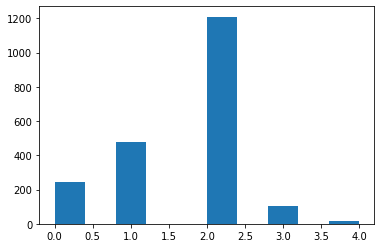

In [619]:
plt.hist(dissdf[2])

In [689]:
def make_list_of_diffs(dissdf,col_0_labels,col_1_labels):
    newlist = []
    for i in np.arange(0,len(dissdf)):
        print(i)
        oldi = dissdf[0][i]
        oldj = dissdf[1][i]
        
        name0 = get_name_from_val(col_0_labels,overlapping_list[oldi][0])
        print(name0)
        parent0 = get_hierarchy(col_0_labels,name0)

        name1 = get_name_from_val(col_1_labels,overlapping_list[oldi][1][oldj])
        print(name1)
        parent1 = get_hierarchy(col_1_labels,name1)
        
        newlist.append([oldi,name0,parent0,oldj,name1,parent1])
    return newlist
    

In [713]:
diss1 = dissdf[dissdf[2]==1].reset_index()
diss2 = dissdf[dissdf[2]==2].reset_index()
diss3 = dissdf[dissdf[2]==3].reset_index()
diss4 = dissdf[dissdf[2]==4].reset_index()
disshigh = dissdf[dissdf[2]>4].reset_index()

In [707]:
difflist = make_list_of_diffs(disshigh,lab_fischer,lab_sigma)

In [708]:
dfdiff = pd.DataFrame(difflist)

In [709]:
dfdiff.to_csv('/Users/emilydennis/Desktop/dfdiffhigh.csv')

In [714]:
# want to know the locations of overlap: how many voxels and where?

In [784]:
# where does A == a and B == b?
def get_voxel_coords(volA, indexA, volB, indexB):
    mA = volA==overlapping_list[indexA][0]
    mB = volB==overlapping_list[indexA][1][indexB]
    mC = mA*mB
    return np.nonzero(mC)

In [808]:
vx = get_voxel_coords(fischer,141,sigma,2)

In [820]:
val=20
print(vx[0][val],vx[1][val],vx[2][val])

586 354 315


In [796]:
#z y x

2731

In [832]:
get_name_from_val(lab_fischer,96)

'cortex'

In [835]:
lab_sigma[lab_sigma.ID> 140]

,atlas,ID,name,praid,parent
26,waxholm,141.0,entorhinal_cortex,3012.0,retrohippocampal
27,waxholm,142.0,entorhinal_cortex,3012.0,retrohippocampal
28,waxholm,151.0,fasciola_cinereum,3000.0,hippocampal_formation
29,waxholm,152.0,fasciola_cinereum,3000.0,hippocampal_formation
30,tohoku,161.0,frontal_association_cortex,1130.0,frontal_pole
...,...,...,...,...,...
229,waxholm,1152.0,ventral_hippocampal_commissure,12000.0,medial_forebrain_bundle
230,waxholm,1161.0,periventricular_grey,9110.0,thalamus
231,waxholm,1162.0,periventricular_grey,9110.0,thalamus
232,sigma,1171.0,ventricular_system,13000.0,ventricles
